In [2]:
import typing as t

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt

In [3]:
torch.manual_seed(0)

In [4]:
N_DOTS = 2000
START_V, END_V = 0, 10

observed_data = torch.zeros((N_DOTS, 2))
observed_data[:, 0] = torch.arange(START_V, END_V, step=(END_V - START_V) / N_DOTS)
observed_data[:, 1] = torch.sin(observed_data[:, 0])

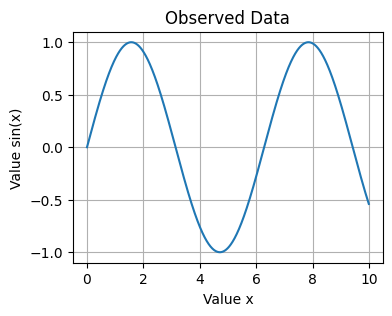

In [5]:
plt.figure(figsize=(4, 3))
plt.title('Observed Data')
plt.plot(observed_data[:, 0], observed_data[:, 1])
plt.xlabel('Value x')
plt.ylabel('Value sin(x)')
plt.grid(True)
plt.show()

In [6]:
BATCH_SIZE = 128

loader = DataLoader(observed_data, batch_size=BATCH_SIZE, shuffle=True)
# sample_batch = next(iter(loader))
# print(sample_batch.shape)  # torch.Size([128, 2])

In [7]:
def create_discriminator() -> nn.Module:
  # creates discriminator network
  return nn.Sequential(
      nn.Linear(2, 256),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(256, 128),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Dropout(0.2),

      nn.Linear(64, 1),
      nn.Sigmoid()
  )

def create_generator() -> nn.Module:
  # creates generator network
  return nn.Sequential(
      nn.Linear(2, 16),
      nn.ReLU(),

      nn.Linear(16, 32),
      nn.ReLU(),

      nn.Linear(32, 2)
  )

In [8]:
def select_device() -> str:
  return 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
# TRAIN DISCRIMINATOR

def train_dis_on_real_batch(
    model: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    real_batch: torch.tensor,
    device: str
  ) -> float:

  batch_size = real_batch.shape[0]
  real_samples = real_batch.to(device)
  opt.zero_grad()

  output = model(real_samples)
  true_labels = torch.ones((batch_size, 1), device=device)
  loss = loss_fn(output, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value


def train_dis_on_fake_batch(
    model: nn.Module,
    fake_creator: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    batch_size: int,
    device: str
) -> float:

  noize = torch.rand((batch_size, 2))
  noize = noize.to(device)
  fake_output = fake_creator(noize)

  opt.zero_grad()

  output = model(fake_output)
  true_labels = torch.zeros((batch_size, 1), device=device)
  loss = loss_fn(output, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value

In [10]:
# TRAIN GENERATOR

def train_gen(
    model: nn.Module,
    dis: nn.Module,
    opt: torch.optim.Optimizer,
    loss_fn: t.Callable,
    batch_size: int,
    device: str
) -> float:

  noize = torch.rand((batch_size, 2))
  noize = noize.to(device)
  opt.zero_grad()

  fake_output = model(noize)
  dis_detections = dis(fake_output)
  true_labels = torch.ones((batch_size, 1), device=device)
  loss = loss_fn(dis_detections, true_labels)
  loss.backward()

  loss_value = loss.detach().cpu().item()

  opt.step()
  return loss_value

In [11]:
# USING GENERATOR

def generate(model: nn.Module, batch_size: int, device: str) -> torch.tensor:
  with torch.no_grad():
    noize = torch.rand((batch_size, 2))
    # print(noize.shape)
    noize = noize.to(device)
    gen_output = model(noize)
    gen_output = gen_output.detach().cpu()
  return gen_output

In [12]:
def train_epoch(
    dis: nn.Module,
    gen: nn.Module,
    loader: DataLoader,
    loss_fn: t.Callable,
    dis_opt: torch.optim.Optimizer,
    gen_opt: torch.optim.Optimizer,
    device: str
) -> t.Tuple[float, float]:

  dis_epoch_loss = 0
  gen_epoch_loss = 0

  for batch in loader:
    dis_true_loss = train_dis_on_real_batch(
        model=dis,
        opt=dis_opt,
        loss_fn=loss_fn,
        real_batch=batch,
        device=device
    )
    dis_fake_loss = train_dis_on_fake_batch(
        model=dis,
        fake_creator=gen,
        opt=dis_opt,
        loss_fn=loss_fn,
        batch_size=batch.shape[0],
        device=device
    )
    gen_loss = train_gen(
        model=gen,
        dis=dis,
        opt=gen_opt,
        loss_fn=loss_fn,
        batch_size=batch.shape[0],
        device=device
    )

    dis_epoch_loss += (dis_true_loss + gen_epoch_loss) / 2
    gen_epoch_loss += gen_loss

  dis_epoch_loss = dis_epoch_loss / len(loader)
  gen_epoch_loss = gen_epoch_loss / len(loader)

  return dis_epoch_loss, gen_epoch_loss

In [13]:
device = select_device()
learning_rate = 0.001

loss_function = nn.BCELoss().to(device)
gen = create_generator().to(device)
dis = create_discriminator().to(device)

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=learning_rate)

Dis loss 2.6370260850526392 	 Gen loss 0.7761137783527374
Dis loss 6.012435429729521 	 Gen loss 1.555164374411106


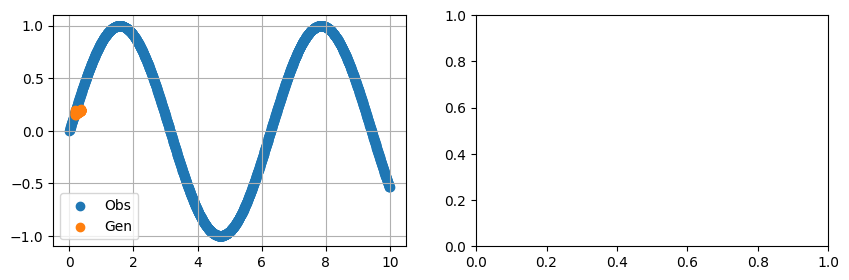

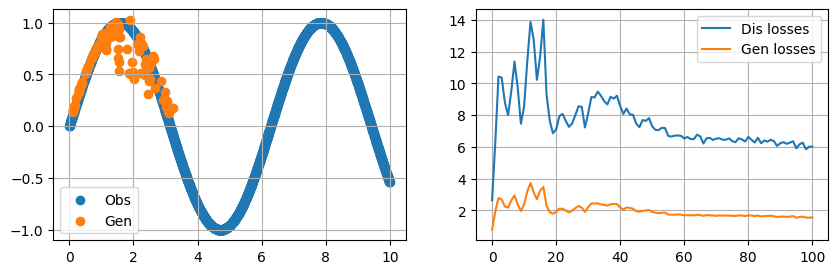

Dis loss 5.2658626874908805 	 Gen loss 1.4381809160113335


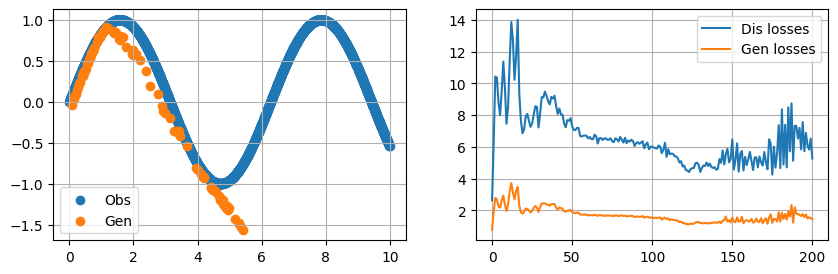

Dis loss 5.398097634315491 	 Gen loss 1.6023597568273544


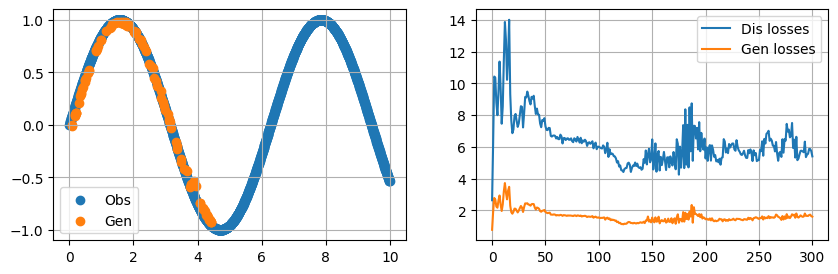

Dis loss 7.932075361721218 	 Gen loss 1.9161592572927475


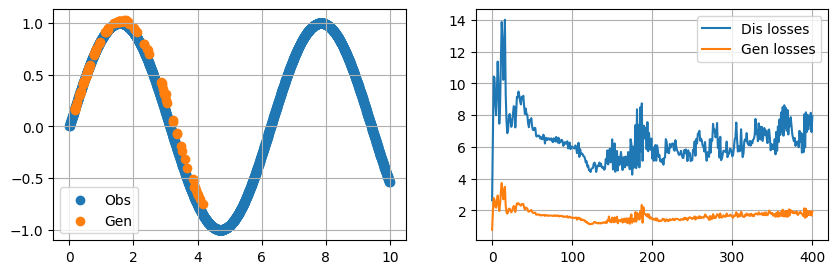

Dis loss 7.959072948433459 	 Gen loss 1.8901937901973724


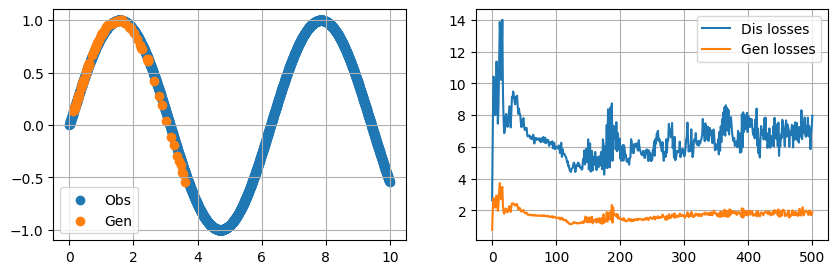

Dis loss 6.58017148822546 	 Gen loss 1.662632018327713


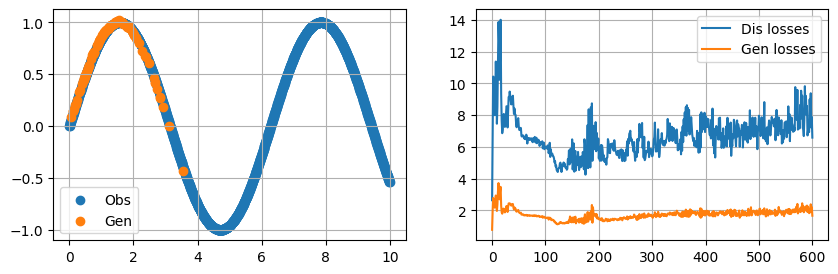

Dis loss 7.455032043159008 	 Gen loss 1.9522056877613068


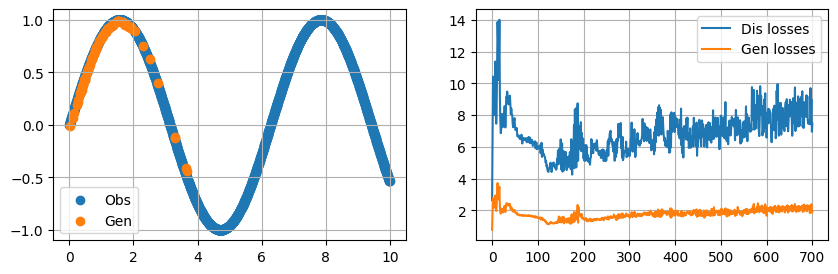

Dis loss 10.483935594558716 	 Gen loss 2.4893497601151466


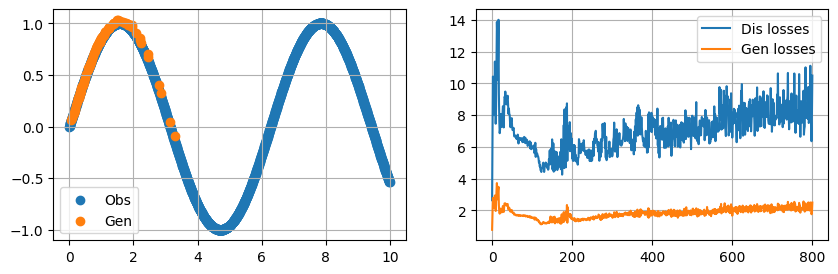

Dis loss 9.005038725212216 	 Gen loss 2.3797937780618668


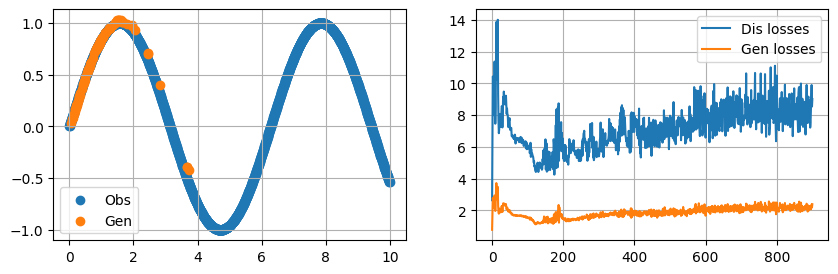

Dis loss 8.762608332559466 	 Gen loss 2.133919060230255


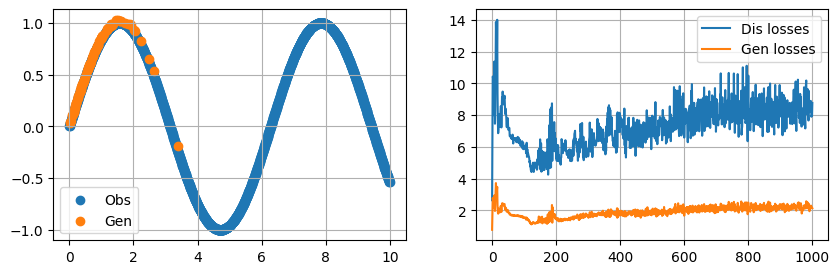

Dis loss 8.241655342746526 	 Gen loss 2.4068133383989334


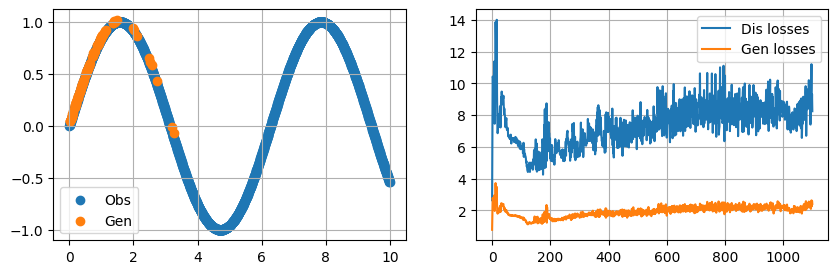

Dis loss 7.132817190140486 	 Gen loss 1.8399990275502205


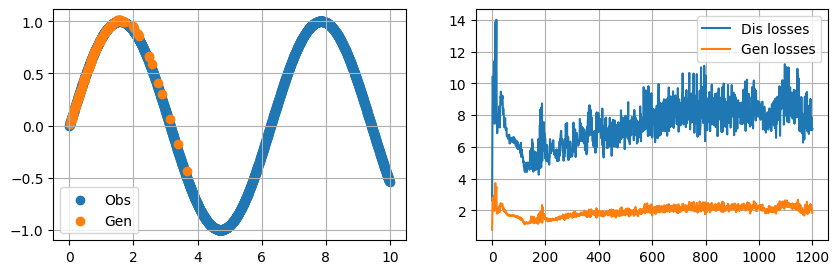

Dis loss 9.904599093832076 	 Gen loss 2.2985858768224716


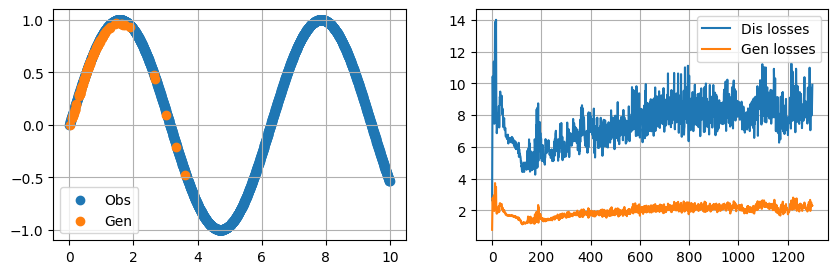

Dis loss 7.137507446110249 	 Gen loss 1.963715024292469


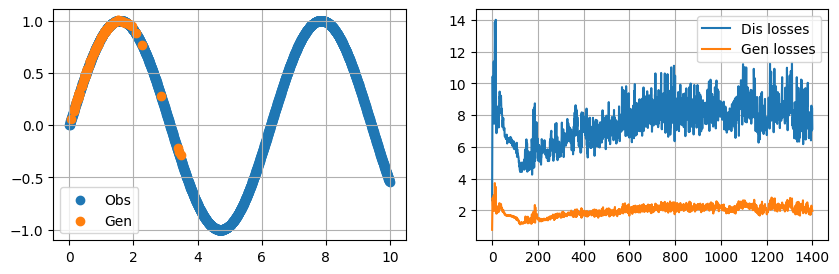

Dis loss 9.999610505998135 	 Gen loss 2.567645162343979


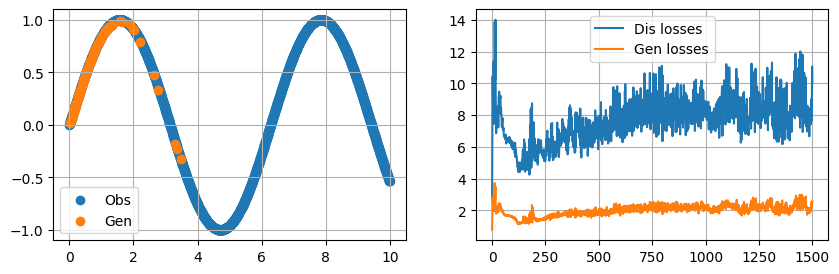

Dis loss 8.291514618787915 	 Gen loss 2.5822667106986046


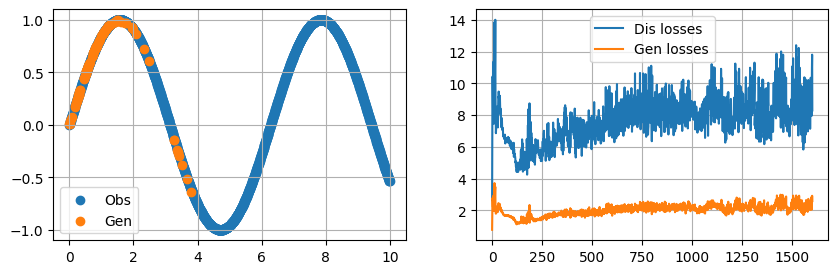

Dis loss 6.7260922635905445 	 Gen loss 2.118391014635563


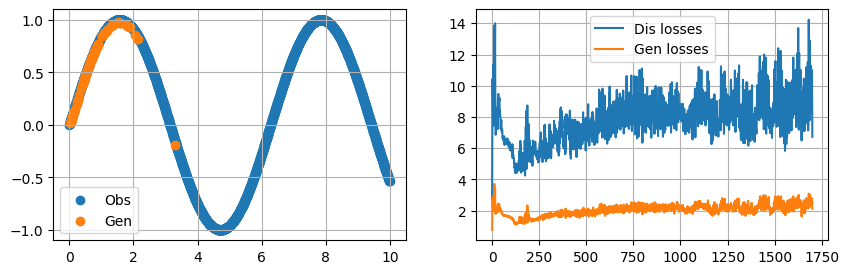

Dis loss 11.656758334022015 	 Gen loss 3.134359732270241


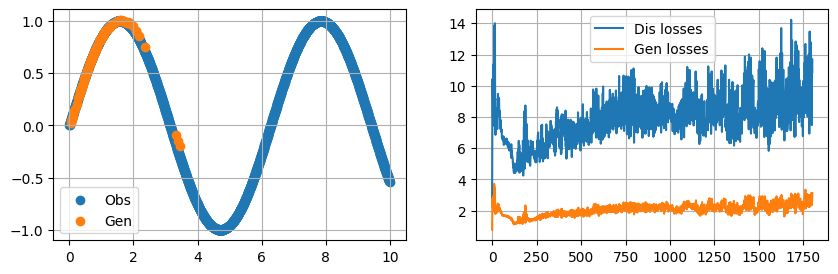

Dis loss 11.517150496598333 	 Gen loss 2.611896365880966


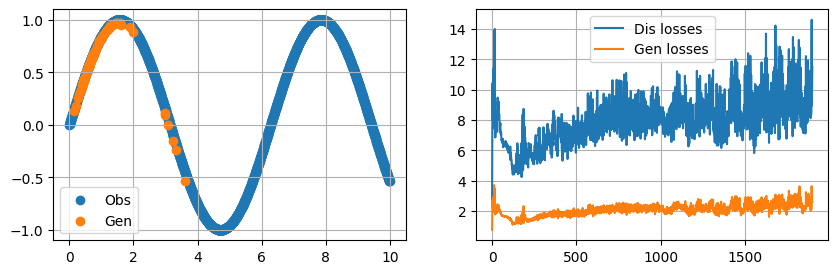

In [14]:
dis_losses = []
gen_losses = []

for e in range(2_000):

  dis_epoch_loss, gen_epoch_loss = train_epoch(
      dis=dis,
      gen=gen,
      loader=loader,
      loss_fn=loss_function,
      dis_opt=dis_optimizer,
      gen_opt=gen_optimizer,
      device=device
  )

  dis_losses.append(dis_epoch_loss)
  gen_losses.append(gen_epoch_loss)

  if e % 100 == 0:
    print('Dis loss', dis_epoch_loss, '\t', 'Gen loss', gen_epoch_loss)
    generated_data = generate(model=gen, batch_size=100, device=device)
    generated_data = generated_data.numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    axes[0].scatter(observed_data[:, 0], observed_data[:, 1], label='Obs')
    axes[0].scatter(generated_data[:, 0], generated_data[:, 1], label='Gen')
    axes[0].grid(True)
    axes[0].legend()

    if e == 0:
      continue

    plot_x = list(range(e + 1))
    axes[1].plot(plot_x, dis_losses, label='Dis losses')
    axes[1].plot(plot_x, gen_losses, label='Gen losses')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

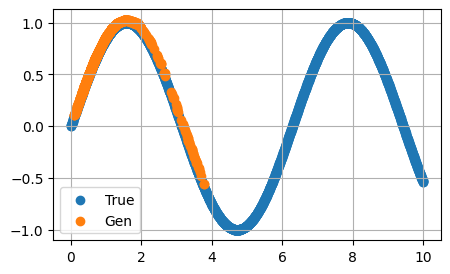

In [16]:
gen.eval()
generated_data = generate(model=gen, batch_size=1000, device=device)
generated_data = generated_data.numpy()

plt.figure(figsize=(5, 3))
plt.scatter(observed_data[:, 0], observed_data[:, 1], label='True')
plt.scatter(generated_data[:, 0], generated_data[:, 1], label='Gen')
plt.grid(True)
plt.legend()
plt.show()

In [19]:
torch.save(dis.state_dict(), 'discriminator.pt')
torch.save(gen.state_dict(), 'generator.pt')

In [20]:
!ls -lah

total 192K
drwxr-xr-x 1 root root 4.0K Nov 20 17:15 .
drwxr-xr-x 1 root root 4.0K Nov 20 17:05 ..
drwxr-xr-x 4 root root 4.0K Nov 16 14:23 .config
-rw-r--r-- 1 root root 168K Nov 20 17:15 discriminator.pt
-rw-r--r-- 1 root root 5.2K Nov 20 17:15 generator.pt
drwxr-xr-x 1 root root 4.0K Nov 16 14:27 sample_data


In [21]:
dis_traced = torch.jit.trace(func=dis, example_inputs=torch.rand((2, 2)))
gen_traced = torch.jit.trace(func=gen, example_inputs=torch.rand((2, 2)))

In [30]:
dis_traced.save('discriminator_traced.pt')
gen_traced.save('generator_traced.pt')

In [31]:
!ls -lah

total 396K
drwxr-xr-x 1 root root 4.0K Nov 20 17:23 .
drwxr-xr-x 1 root root 4.0K Nov 20 17:05 ..
drwxr-xr-x 4 root root 4.0K Nov 16 14:23 .config
-rw-r--r-- 1 root root 168K Nov 20 17:15 discriminator.pt
-rw-r--r-- 1 root root 187K Nov 20 17:23 discriminator_traced.pt
-rw-r--r-- 1 root root 5.2K Nov 20 17:15 generator.pt
-rw-r--r-- 1 root root  16K Nov 20 17:23 generator_traced.pt
drwxr-xr-x 1 root root 4.0K Nov 16 14:27 sample_data


In [36]:
gen_traced = torch.jit.load('generator_traced.pt', map_location=device)

In [37]:
%%timeit

# testing default generator
for _ in range(1000):
  with torch.no_grad():
    noize = torch.rand((2, 2))
    noize = noize.to(device)
    gen_output = gen(noize)

85.4 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [38]:
%%timeit

# testing traced generator
for _ in range(1000):
  with torch.no_grad():
    noize = torch.rand((2, 2))
    noize = noize.to(device)
    gen_output = gen_traced(noize)

49.5 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
